In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Original data downloaded from: https://www.gold.org/goldhub/data/gold-prices
# An account is required to download the data in .xlsx format
# I extracted the daily closing gold price in USD from the .xlsx file and saved them as .csv
# in the directory "gold/" located together with this Jupyter notebook

base_dir = "gold/"

data = pd.read_csv(base_dir + "gold_price_usd.csv")
# force datetimes to datetime objects from strings
data["datetime"] = pd.to_datetime(data["datetime"])
# take the daily change in gold price
data["gold_price_change"] = data["gold_price_usd"].diff()
# restrict the data past a certain date if necessary
data = data[data["datetime"] >= pd.to_datetime("2008-01-01")]

display(data)

,datetime,gold_price_usd,gold_price_change
7567,2008-01-01,833.75,0.00
7568,2008-01-02,846.75,13.00
7569,2008-01-03,858.85,12.10
7570,2008-01-04,855.00,-3.85
7571,2008-01-07,859.25,4.25
...,...,...,...
10966,2021-01-11,1847.25,-15.65
10967,2021-01-12,1841.25,-6.00
10968,2021-01-13,1858.85,17.60
10969,2021-01-14,1841.75,-17.10


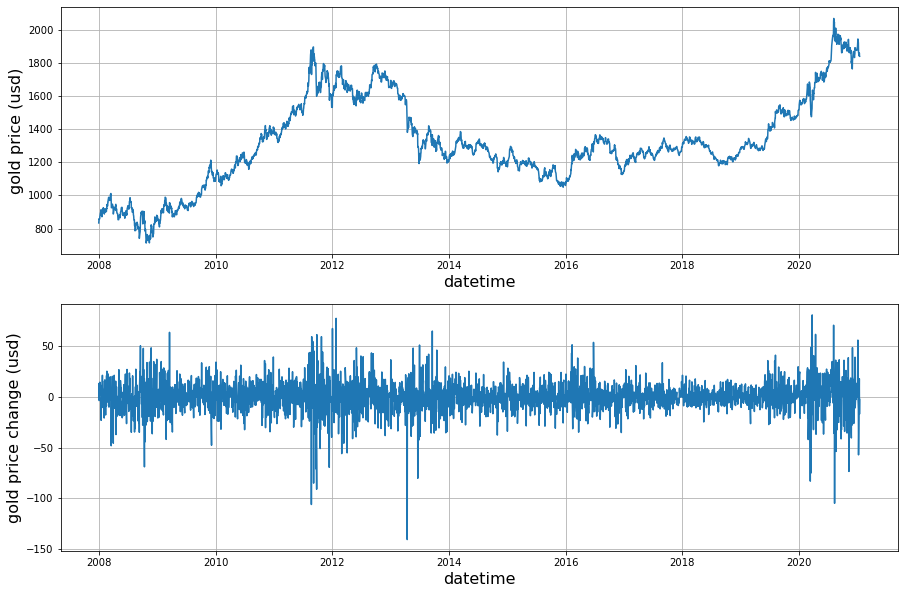

In [2]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(data["datetime"], data["gold_price_usd"])
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data["datetime"], data["gold_price_change"])
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price change (usd)", fontsize=16)
plt.grid(True)
plt.show()

In [3]:
# Build hidden markov models to model the change in gold price

# Quick Guide to Hidden Markov Models
# -----------------------------------
#
# Inputs
# ------
# X: np.array of observable states
#
# Outputs
# -------
# Z: np.array of hidden internal states corresponding to X
#
# Model Parameters
# ----------------
# startprob_: np.array of start probabilities
# transmat_: np.array of internal states transition
# means_: np.array of observable emission probability means
# covars_: np.array of observable emission probability covariances

def gaussian_emission(mu, var):
    """
    Inputs
    ------
    mu: float
        mean
    var: float
        variance
        
    Returns
    -------
    r: float
        sample from gaussian distribution
    """
    r = np.random.normal(mu, np.sqrt(var))
    return r

# Build a Gaussian emission HMM using hmmlearn for the daily change in gold price.
# Use Gaussian emission as it is the most straight forward model and the easiest to interpret.
# Assume that there are 3 different hidden states in the gold price data corresponding to low volatility, 
# medium volatility and high volatility. This is of course a very simplistic assumption and there are other 
# possible assumptions. Assume that the covariance matrix is full, giving the greatest degrees of freedom 
# to the system. Iterate 50 times during the fitting process. 

X = data["gold_price_change"].values.reshape(-1, 1)
model = hmm.GaussianHMM(n_components = 3, covariance_type = "full", n_iter = 50)
model.fit(X)
Z = model.predict(X)
states = pd.unique(Z)

print("Unique states:")
print(states)
print("Start probabilities:")
print(model.startprob_)
print("Transition matrix:")
print(model.transmat_)
print("Gaussian distribution means:")
print(model.means_)
print("Gaussian distribution covariances:")
print(model.covars_)
print("Log likelihood of X:")
print(model.score(X))

Unique states:
[0 1 2]
Start probabilities:
[1.00000000e+00 5.95557161e-19 9.00728803e-46]
Transition matrix:
[[0.52816914 0.46733569 0.00449517]
 [0.62155015 0.37410218 0.00434767]
 [0.00406058 0.01409955 0.98183988]]
Gaussian distribution means:
[[ 0.38826286]
 [ 0.55352703]
 [-0.42537917]]
Gaussian distribution covariances:
[[[ 38.63001705]]

 [[231.31359584]]

 [[620.73902224]]]
Log likelihood of X:
-13455.495390184893


In [4]:
# State 0: low volatility, 1: medium volatility, 2: high volatility
# Starting state probabilities are [1, 0, 0] which means that X starts off in the low volatility state
# The transition matrix tells us that systems in state 0 have a 52% chance of staying in state 0, 
# and a 48% chance of moving to state 1, while systems in state 2 have a 98% chance of staying in state 2. 
# Therefore in general, the market fluctuates between low and medium volatility, while rarely moving into the
# high volatility state. However once the market enters the high volatility state, it tends to remain there
# for a significant period of time before returning to general conditions.

# The Gaussian distribution parameters show that in state 0 the change in gold price has a mean of 0.38 USD 
# with a variance of 37.91 USD, while in state 2 the change in gold price has a mean of -0.36 USD with a 
# variance of 620.11 USD. The extremely large variances indicate that using 3 hidden states might not have 
# captured the emission probabilities precisely. However the variances do support the low volatility, 
# medium volatility and high volatility states assumption.

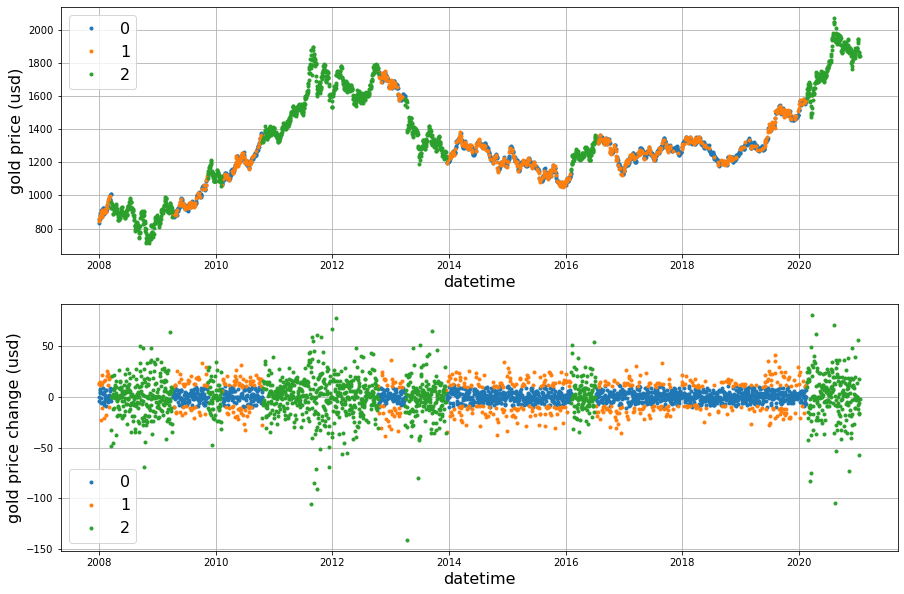

In [5]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_usd"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_change"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price change (usd)", fontsize=16)
plt.show()

In [6]:
# From the graphs, we find that periods of high volatility correspond to periods of difficult economic times 
# such as the Lehmann shock from 2008 to 2009, the recession of 2011-2012 and the covid19 pandemic induced 
# recession in 2020. Furthermore, we see that the price of gold tends to rise during times of uncertainty as 
# investors increase their purchases of gold which is seen as a safe and stable asset.

# The current model has been able to give us a good representation of the hidden states, but it is too rough to 
# do any meaningful predictions. Instead of training one model on the entire dataset, what should be done to get 
# a more precise model is to split the data into several windows and train one model for each window. 
# For example, one model for each month. This set of localized models should be more precise than the global model
# which we made in this post.

In [7]:
# Break the time series into Train and Test sets. As a start choose 2020 as the cut off point
want = "2020-01-01"
Train = data[data["datetime"] < pd.to_datetime(want)]
Test = data[data["datetime"] >= pd.to_datetime(want)]

# One possible method of performing predictions is as follows:
# 1. Split the training data time series into several windows of N days each. For example, 1 month/30 days each.
# 2. For each window of train data, train a Hidden Markov Chain Gaussian emission model.
# 3. Calculate the log-likelihood for that particular window of data.
# 4. Split the test data time series into several windows of N days each.
# 5. For each window of test data, train a Hidden Markov Chain Gaussian emission model.
# 6. Calculate the log-likelihood for that particular window of data.
# 7. Search for the model/window in the training data which has the same log-likelihood within some threshold.
# 8. Use the corresponding training data gold price change as the test data predictions.
def sliding_hmm_models(Train, window = 30, n_components = 3, covariance_type = "full", n_iter = 10):
    """
    Build HMM models for a selected sliding window for the entire time series.
    
    Inputs
    ------
    Train: pd.DataFrame
        Training dataset
    window: int
        number of days to use in each window
    n_components: int
        number of HMM hidden states
    covariance_type: str
        covariance type. 
    n_iter: int
        number of iterations to execute
    
    Returns
    -------
    hmm_models: dict
        dictionary containing the training data, models, hidden states and scores for each window. Dictionary
        keys are the window indices
    scores: np.array
        np.array of all the model scores for easier reference
    """
    hmm_models = {}
    for i in range(0, len(Train) - window + 1):
        X_train = Train.iloc[i:i + window]["gold_price_change"].values.reshape(-1, 1)
        model = hmm.GaussianHMM(n_components = n_components, covariance_type = covariance_type, n_iter = n_iter)
        try:
            model.fit(X_train)  
            hmm_models[i] = {}
            hmm_models[i]["model"] = model
            hmm_models[i]["X_train"] = X_train.copy()
            hmm_models[i]["score"] = model.score(X_train)
            hmm_models[i]["Z_train"] = model.predict(X_train)
        except:
            print("Failed to build model for i = {}".format(i))
            hmm_models[i] = {}
            hmm_models[i]["model"] = None
            hmm_models[i]["X_train"] = X_train.copy()
            hmm_models[i]["score"] = -1e99
            hmm_models[i]["Z_train"] = None
    # Extract the scores (log-likelihood) for each model/index for easier referencing later on
    scores = []
    for i in sorted(hmm_models.keys()):
        scores.append(hmm_models[i]["score"])   
    scores = np.array(scores)
    return hmm_models, scores

#hmm_models, scores = sliding_hmm_models(Train, window = 10, n_components = 2)

In [8]:
# Make sliding predictions on the Test set using the Train set models
def sliding_hmm_predictions(Test, scores, window = 30, n_components = 3, covariance_type = "full", n_iter = 10):
    """
    Perform HMM predictions for a selected sliding window for the entire time series.
    
    Inputs
    ------
    Test: pd.DataFrame
        test data set to predict on
    scores: np.array
        np.array of scores for the training data models
    window: int
        number of days to use in each window
    n_components: int
        number of HMM hidden states
    covariance_type: str
        covariance type. 
    n_iter: int
        number of iterations to execute
    
    Returns
    -------
    predictions: np.array
        np.array of predictions in the gold price change
    """
    predictions = []
    for i in range(0, len(Test) - window + 1):
        X_test = Test.iloc[i:i + window]["gold_price_change"].values.reshape(-1, 1)
        model = hmm.GaussianHMM(n_components = 3, covariance_type = "full", n_iter = 10)
        try:
            model.fit(X_test)
            want = np.argmin(abs(scores - model.score(X_test)))
            # todo: implement threshold!!!
            predictions.append(Train.iloc[want + window]["gold_price_change"])
        except:
            print("Failed to build model for i = {}".format(i))
    return np.array(predictions)

#predictions = sliding_hmm_predictions(Test, scores, window = 10, n_components = 2)

In [9]:
#plt.figure(figsize = (15, 5))
#plt.plot(Test.iloc[90:]["gold_price_change"].values)
#plt.plot(predictions)
#plt.show()

In [10]:
# LSTM neural networks are another set of interesting models which have been successfully applied to modelling
# time series data. We attempt to model the gold price time series with an LSTM model from Keras/Tensorflow.

# Prepare the data for LSTM neural network modelling 
dataset = data["gold_price_usd"].values

# Neural networks require that the data is scaled properly
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

data["gold_price_scaled"] = dataset.copy()

# Use 2010-2018 as the training set, and 2019-2020 as the test set:
want = "2019-01-01"
train = data[data["datetime"] < pd.to_datetime(want)]["gold_price_scaled"].values
test = data[data["datetime"] >= pd.to_datetime(want)]["gold_price_scaled"].values

print(train.shape, test.shape)

(2870,) (534,)


In [11]:
# The time series data must then be formatted properly for LSTM modelling.
# See https://keras.io/api/layers/recurrent_layers/lstm/ for more information
def create_lstm_data(data, lag = 1):
    """
    Creates features and targets suitable for LSTM modelling
    See https://keras.io/api/layers/recurrent_layers/lstm/ for more information
    
    Inputs
    ------
    data: np.array
        One dimensional time series np.array to be processed
        This array should not have undergone the process: .reshape(-1, 1)
    lag: int
        Amount of historical lag used to create the feature set
    
    Outputs
    -------
    X, y: np.array, np.array
        Feature and target arrays
    """
    if lag > len(data):
        # lag cannot be more than data length
        return None
    
    if len(np.shape(data)) > 1 and np.shape(data)[1] == 1:
        # if for some reason data was detected to have undergone reshape(-1, 1)
        # force it back to a standard 1 dimensional np.array
        data = data.reshape(-1)
    elif len(np.shape(data)) > 1 and np.shape(data)[1] > 1:
        # this function works only for 1D arrays. Anything more than that will not work
        return None
        
    # if there are no pressing issues, create the LSTM compatible data 
    # with the specified historical lag
    X = np.zeros([len(data) - lag, lag])
    y = np.zeros(len(data) - lag)
    for n in range(len(data) - lag):
        X[n] = data[n:n + lag]
        y[n] = data[n + lag]
        
    # X needs to be a 3D tensor with shape: [batch, timesteps, feature]
    # In this case we treat the lagged data as features, and assume a timestep of 1
    X = X.reshape([X.shape[0], 1, X.shape[1]])
    
    return X, y

def demo():
    # demonstrates how to use create_lstm_data()
    X = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17 ,18 ,19, 20])
    X, y = create_lstm_data(X, 3)

    for i in range(len(X)):
        print(X[i], y[i])

In [12]:
lag = 30 # lag of N days

# train X and y
X_train, y_train = create_lstm_data(train, lag)
# test X and y
X_test, y_test = create_lstm_data(test, lag)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2840, 1, 30) (2840,) (504, 1, 30) (504,)


In [13]:
def make_lstm_model(X_train, y_train, units=50, epochs=100, batch_size=32, verbose=2):
    """
    Wrapper function to build the LSTM model
    
    Inputs
    ------
    X_train: np.array
        LSTM formatted training features
    y_train: np.array
        LSTM formatted training targets
    units: int
        number of nodes to use in the neural network
    epochs: int
        number of training epochs to use
    batch_size: int
        number of data points to use per training epoch
    verbose: int
        chattiness of the model. Set to 0 to shut the model up. Set to 2 for maximum chattiness
    
    Returns
    -------
    model: Tensorflow neural network model
    """
    model = Sequential()
    model.add(LSTM(units = units, input_shape = [X_train.shape[1], X_train.shape[2]], activation = "relu"))
    model.add(Dense(1))
    
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = verbose)
    
    return model

In [14]:
models = []
y_train_preds = []
y_test_preds =[]

n_models = 20 # number of models to make

# Due to randomness in the training, a few models should be trained!
for i in range(n_models):
    # build LSTM model using X_train and y_train
    model = make_lstm_model(X_train, y_train, units=50, epochs=20, batch_size=32, verbose=0)
    
    # make predictions on both X_train and X_test which the model has not seen before
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # don't forget to perform the inverse scaling operations!
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    
    models.append(model)
    y_train_preds.append(y_train_pred)
    y_test_preds.append(y_test_pred)

y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

print(y_train.shape, y_test.shape)

(2840,) (504,)


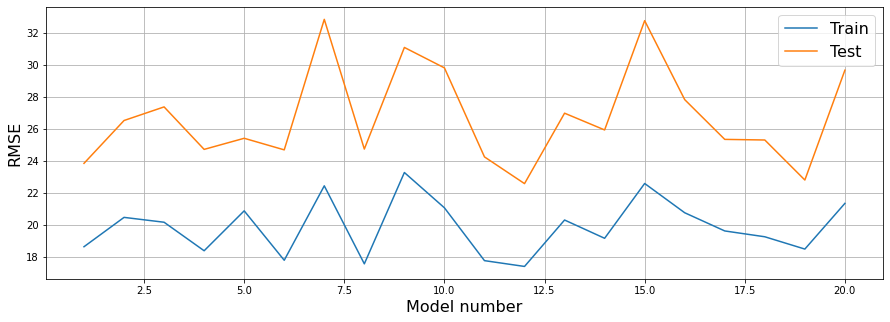

In [15]:
# Check the RMSE per model
train_scores = []
test_scores = []

for i in range(n_models):
    train_score = np.sqrt(mean_squared_error(y_train_orig, y_train_preds[i]))
    test_score = np.sqrt(mean_squared_error(y_test_orig, y_test_preds[i]))
    train_scores.append(train_score)
    test_scores.append(test_score)
    
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1 + n_models), train_scores)
plt.plot(range(1, 1 + n_models), test_scores)
plt.xlabel("Model number", fontsize=16)
plt.ylabel("RMSE", fontsize=16)
plt.grid(True)
plt.legend(["Train", "Test"], fontsize=16)
plt.show()

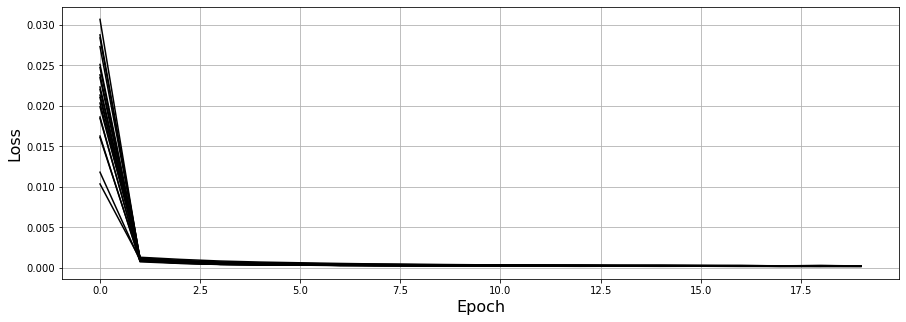

In [16]:
# Check how the loss changes with epochs
plt.figure(figsize = (15, 5))
for i in range(len(models)):
    plt.plot(models[i].history.history['loss'], 'k')
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.grid(True)
plt.show()

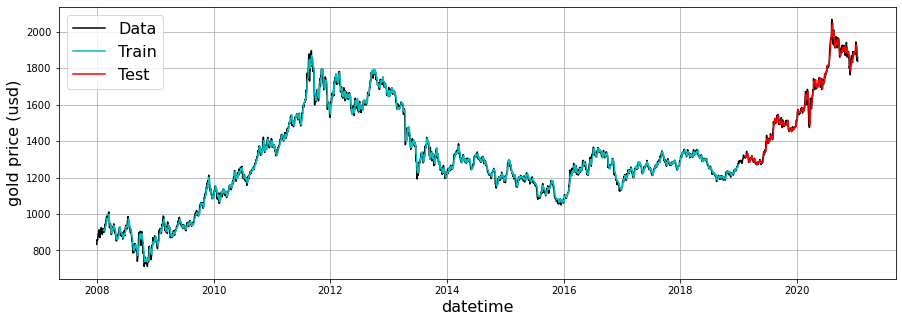

In [17]:
# plot the best performing model:
want = np.argmin(test_scores)

plt.figure(figsize = (15, 5))
# original data
plt.plot(data["datetime"], scaler.inverse_transform(dataset), 'k')
# training predictions
plt.plot(data["datetime"].iloc[lag:len(y_train_pred) + lag], y_train_preds[want], 'c')
# test predictions
plt.plot(data["datetime"].iloc[len(y_train_pred) + lag + lag:], y_test_preds[want], 'r')
plt.legend(["Data", "Train", "Test"], fontsize=16)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.grid(True)
#plt.xlim([pd.to_datetime("2019-01-01"), pd.to_datetime("2021-01-01")])
plt.show()

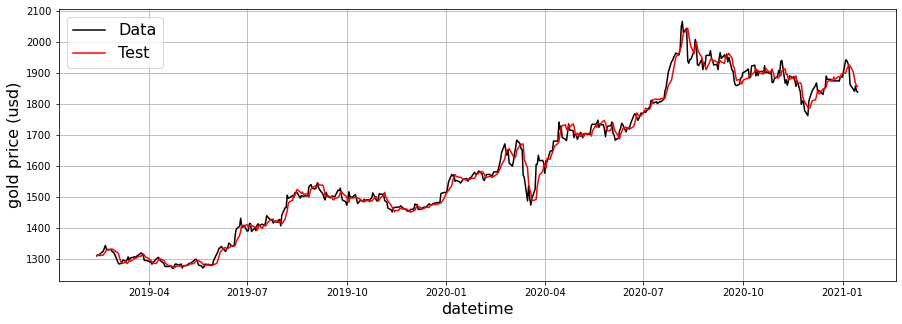

In [18]:
plt.figure(figsize = (15, 5))
plt.plot(data["datetime"].iloc[len(y_train_pred) + lag + lag:], 
         scaler.inverse_transform(dataset)[len(y_train_pred) + lag + lag:], 'k')
plt.plot(data["datetime"].iloc[len(y_train_pred) + lag + lag:], y_test_preds[want], 'r')
plt.legend(["Data", "Test"], fontsize=16)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.grid(True)
plt.show()

In [19]:
# Now use the model to perform predictions for 2021 onwards!
# We predict 3 days into the future

future_dates = [data["datetime"].max() + datetime.timedelta(days = x) for x in range(1, 3 + 1, 1)]

n_iter = len(future_dates) # number of business days into the future to predict

y_future = np.zeros([len(models), n_iter])

for want in range(len(models)):
    for i in range(n_iter):
        if i == 0:
            to_predict = test[-lag:].copy()
            to_predict = to_predict.reshape([1, 1, lag])
            y_future[want, i] = models[want].predict(to_predict)
        else:
            to_predict[0][0][:-1] = to_predict[0][0][1:].copy()
            to_predict[0][0][-1] = y_future[want, i - 1]
            y_future[want, i] = models[want].predict(to_predict)

y_future = scaler.inverse_transform(y_future)

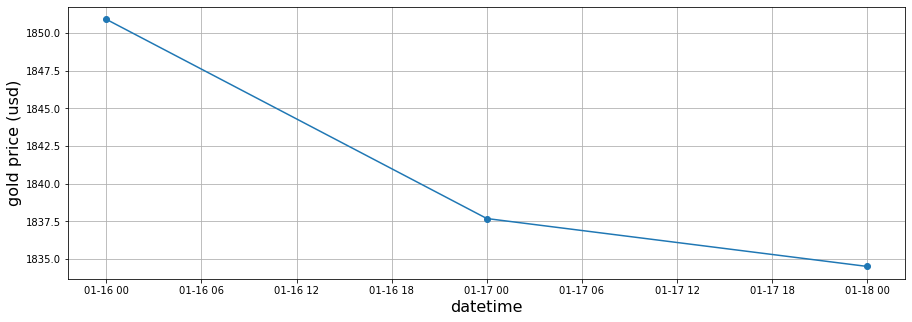

In [20]:
# first try using the best model
want = np.argmin(test_scores)
plt.figure(figsize = (15, 5))
plt.plot(future_dates, y_future[want, :], "-o")
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.grid(True)
plt.show()

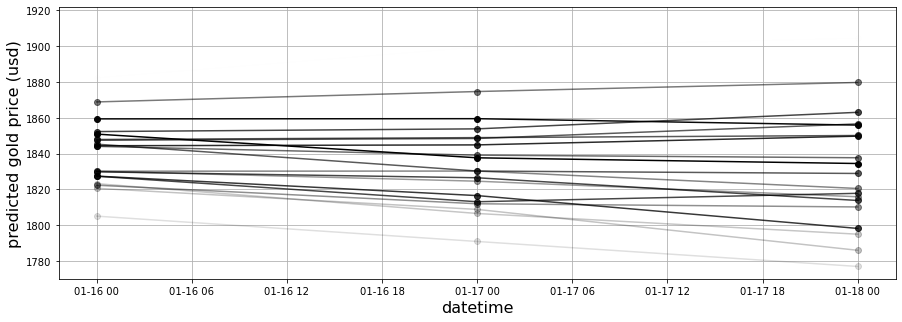

In [21]:
# try plotting all models individually
# the results are extremely varied...
alphas = MinMaxScaler().fit_transform(1/np.array(test_scores).reshape(-1, 1)).reshape(-1)
plt.figure(figsize = (15, 5))
for want in range(len(test_scores)):
    # Use dark lines for predictions by good models, and faint lines for predictions by bad models
    plt.plot(future_dates, y_future[want, :], "k-o", alpha = alphas[want])
plt.grid(True)
plt.xlabel("datetime", fontsize = 16)
plt.ylabel("predicted gold price (usd)", fontsize = 16)
plt.show()

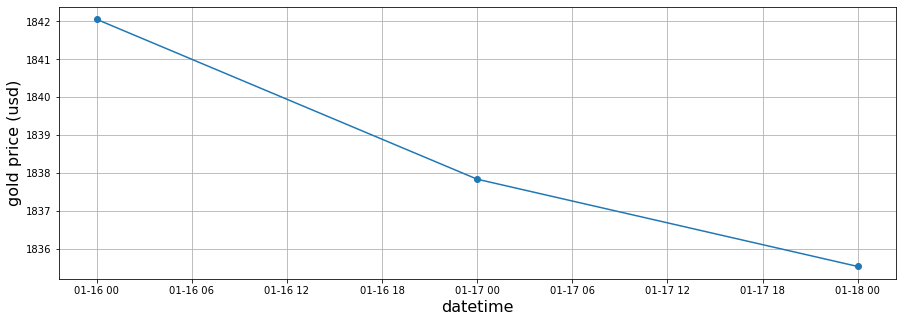

In [22]:
# averages of all the models:
plt.figure(figsize = (15, 5))
plt.plot(future_dates, y_future.mean(axis=0), "-o")
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.grid(True)
plt.show()